# Exploratory data analysis on the ICBA dairy cattle data

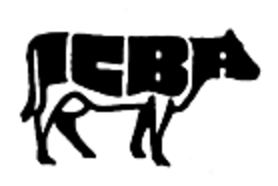

In [1]:
from IPython import display
display.Image("../ICBA_logo.png")

## Summary
This is a dataset of a single dairy farm in israel. There are two tables, the first is the feed data per group of cows in a daily time series in the years 2005-2022. The second table is the lab results of the milk analysis for the dairy cows in a monthly time series.

## Importat notes
- The groups are not static, cows can pass between them in cycles of milking and period of dryness.
- Not all groups gives milk, so it would be wise to omit non-relevane groups.
- The lab results are messured monthly, and the feed is daily, so parhapse we need only the few days prior to the sample taking. We can eather do a mean of few days prior, or seperating them so the model could learn the important period to effect each attribute of the sample quality. It is reasonable to assume that different attributes changes in different rates from the feed to the milk.
- Allthough the main focus is to increase the milk quality, the milk quantity also needs to be taken into account. We want the milk quantity to increase or at least be stable.
- Environment temprature is a big factor on the quantity of milk given. So, it might be wise to import weather data to try and explain some of the variability.
- Feed categories alone are not a coherent thing, so breaking apart the categories into rough nutrient measurement can be helpfull for the model to reason and infere from it.

## Data Dictionary

### Feed data
- **Date**: Date daily
- **Group**: Categorical nominal, cattle group
- **Group_name**: Categorical nominal, cattle group name
- **Feed_num**: Categorical nominal, number of feed in a day, usualy 2
- **Feed_ID**: Categorical nominal, feed type ID
- **Feed_name**: Categorical nominal, feed type name
- **Quantity**: Numerical continuouse, quantity of feed type
- **Units**: Categorical nominal, units of the quantity column
- **Num_of_cows**: Numerical descrete, number of cows in the group

### Lab results
- **Date**: Date montly
- **Group**: Categorical nominal, cattle group
- **Milk**: Numerical continuouse, Average milk quantity in kg per day
- **Fat**: Numerical continuouse, Percent of fat in the milk
- **Protein**: Numerical continuouse, Percent of protein in the milk
- **Lactose**: Numerical continuouse, Percent of lactose in the milk
- **Somatic_cells**: Numerical descrete, count of somatic cells in a ml of milk.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
feed_df = pd.read_csv("../data/raw/Feed.csv")
lab_results_df = pd.read_csv("../data/raw/LabResults.csv")

In [4]:
feed_df.sample(10)

,Date,Group,Group_name,Feed_num,Feed_ID,Feed_name,Quantity,Units,Num_of_cows
52486,2006-04-10,11,Heifers3,2,102,dry coarse,154.4,kg,23
1413876,2018-09-13,10,Heifers2,1,22,corn silage,83.7,kg,26
1835096,2021-11-08,16,Heifers0+,2,951,fat,2.0,kg,18
1792046,2021-07-21,13,Heifers0,2,953,general cellulose,15.7,kg,12
136716,2007-02-20,4,Dairy4,2,939,neutral detergent fiber,309.2,kg,69
450904,2010-07-20,3,Dairy3,2,645,salt,2114.4,gram,60
180509,2007-08-07,4,Dairy4,2,652,calcium,8919.2,gram,64
214981,2007-12-23,10,Heifers2,2,965,rumen degradable protein,36.8,kg,31
893664,2014-08-21,3,Dairy3,2,102,dry coarse,587.4,kg,71
955700,2015-02-18,5,Dairy5,1,129,DDGS,122.2,kg,40


In [5]:
lab_results_df.sample(10)

,Date,Group,Milk,Fat,Protein,Lactose,Somatic_cells
771,2017-10-15,3,38.91,4.04,3.42,4.86,265
994,2021-06-14,4,42.66,3.85,3.40,4.84,364
876,2019-07-24,3,44.08,3.39,3.36,4.82,330
591,2014-09-14,5,27.98,3.89,3.57,4.79,301
646,2015-08-24,5,27.17,3.61,3.42,4.83,369
667,2016-01-11,1,35.57,3.24,3.21,4.71,125
364,2010-12-05,4,22.84,4.13,3.56,4.53,308
390,2011-05-13,5,23.44,3.88,3.42,4.69,476
853,2019-02-10,5,28.21,4.33,3.94,4.97,216
373,2011-02-01,3,41.74,3.31,3.14,4.60,1003


Omitting Non-Dairy cattle groups from the data.

In [6]:
feed_df = feed_df.loc[feed_df.Group_name.str.contains("Dairy"),:]

Omitting somatic cells column from lab results.

In [7]:
lab_results_df.drop(columns=["Somatic_cells"], inplace=True)

Loading the feed names and their nutritional measurments

In [8]:
feed_names = pd.read_csv("../data/others/Feed_names.csv")
feed_measure = pd.read_csv("../data/others/Feed_measure.csv")

The feed names are widly variable, but the more consistent and important are the measurments to use as features for the model

In [9]:
feed_measure

,Unnamed: 0,Feed_name
0,5,dry material
1,6,coarse cellulose
2,7,wet material
3,8,metabolic energy
4,9,general protein
5,10,neutral detergent fiber
6,11,calcium
7,12,residual protein
8,14,rumen degradable protein
9,15,dry coarse


Analyzing number of cows in each group per time

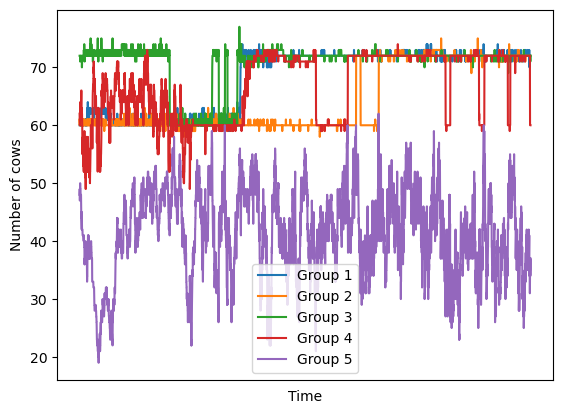

In [10]:
for group in feed_df.Group.unique():
    group_df = feed_df[feed_df["Group"] == group]
    group_df.sort_values("Date", inplace=True)
    group_df.drop_duplicates(subset=["Date"], inplace=True) 
    plt.plot(group_df["Date"], group_df["Num_of_cows"], label=f"Group {group}")
plt.xlabel("Time")
plt.ylabel("Number of cows")
plt.xticks([])
plt.legend()

Normalizing the feed quantities to number of cows in a group

In [11]:
feed_df["Quantity"] = feed_df["Quantity"] / feed_df["Num_of_cows"]

Ploting net energy consumption over time

In [12]:
net_energy = (
    feed_df[feed_df["Feed_name"] == "net energy"]
    .groupby(["Date"])
    .agg({"Quantity":["mean","std"]})
)

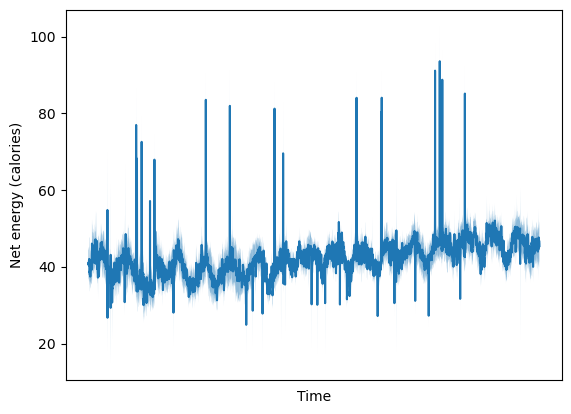

In [13]:
net_energy["Quantity"]["mean"].plot()
plt.xticks([])
plt.xlabel("Time")
plt.ylabel("Net energy (calories)")
plt.fill_between(x=net_energy.index, y1=net_energy["Quantity"]["mean"]+net_energy["Quantity"]["std"], y2=net_energy["Quantity"]["mean"]-net_energy["Quantity"]["std"], alpha=0.5)

Doing the same for carbohydrates, protein and fats

In [14]:
measurments_df = pd.DataFrame()
for measurment in ["carbohydrates", "general protein", "fat"]:
    measure_df = (
        feed_df[feed_df["Feed_name"] == measurment]
        .groupby(["Date"])
        .agg({"Quantity":["mean","std"]})
        .rename(columns=({"Quantity" : measurment}))
    )
    measurments_df = pd.concat([measurments_df, measure_df], axis=1)

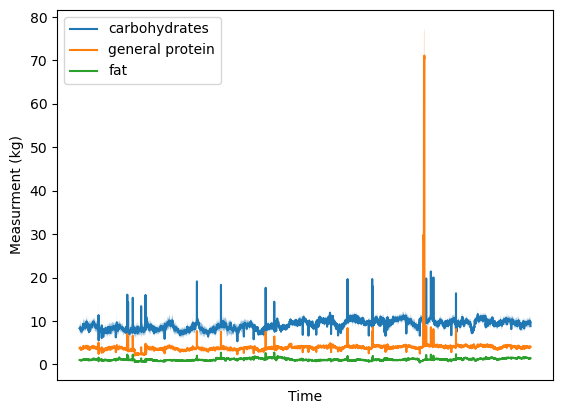

In [15]:
for measurment in ["carbohydrates", "general protein", "fat"]:
    measurments_df[measurment]["mean"].plot(label=measurment)
    plt.fill_between(x=measurments_df.index, y1=measurments_df[measurment]["mean"]+measurments_df[measurment]["std"], y2=measurments_df[measurment]["mean"]-measurments_df[measurment]["std"], alpha=0.5)

plt.xticks([])
plt.xlabel("Time")
plt.ylabel("Measurment (kg)")    
plt.legend()

Repeating with the milk attributes

In [16]:
milk_quantity = (
    lab_results_df
    .groupby(["Date"])
    .agg({"Milk":["mean","std"]})
)

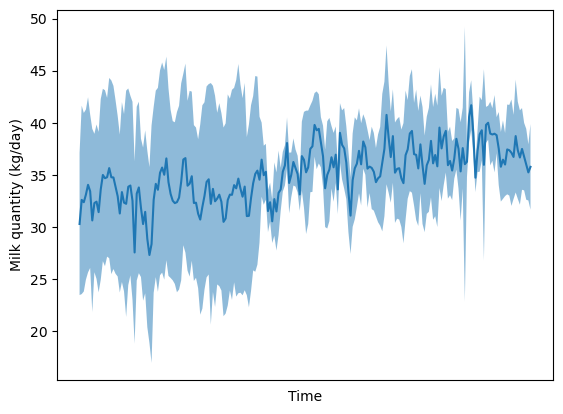

In [17]:
milk_quantity["Milk"]["mean"].plot()
plt.xticks([])
plt.xlabel("Time")
plt.ylabel("Milk quantity (kg/day)")
plt.fill_between(x=milk_quantity.index, y1=milk_quantity["Milk"]["mean"]+milk_quantity["Milk"]["std"], y2=milk_quantity["Milk"]["mean"]-milk_quantity["Milk"]["std"], alpha=0.5)

In [18]:
milk_quanlity = pd.DataFrame()
for measurment in ["Lactose", "Protein", "Fat"]:
    measure_df = (
        lab_results_df
        .groupby(["Date"])
        .agg({measurment:["mean","std"]})
    )
    milk_quanlity = pd.concat([milk_quanlity, measure_df], axis=1)

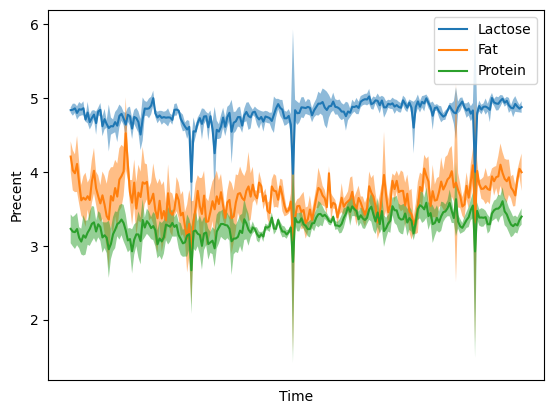

In [19]:
for measurment in ["Lactose", "Fat", "Protein"]:
    milk_quanlity[measurment]["mean"].plot(label=measurment)
    plt.fill_between(x=milk_quanlity.index, y1=milk_quanlity[measurment]["mean"]+milk_quanlity[measurment]["std"], y2=milk_quanlity[measurment]["mean"]-milk_quanlity[measurment]["std"], alpha=0.5)

plt.xticks([])
plt.xlabel("Time")
plt.ylabel("Precent")    
plt.legend()

Decomposing the Milk quantity to identify and seperate trend, seasonality and residuals.

In [52]:
milk_quantity_mean = milk_quantity["Milk"]["mean"].reset_index()
milk_quantity_mean.index = pd.DatetimeIndex(data=milk_quantity_mean["Date"])
milk_quantity_mean.drop(columns=["Date"], inplace=True)
milk_quantity_yearly = milk_quantity_mean.resample('m').sum()["mean"]

<AxesSubplot: xlabel='Date'>

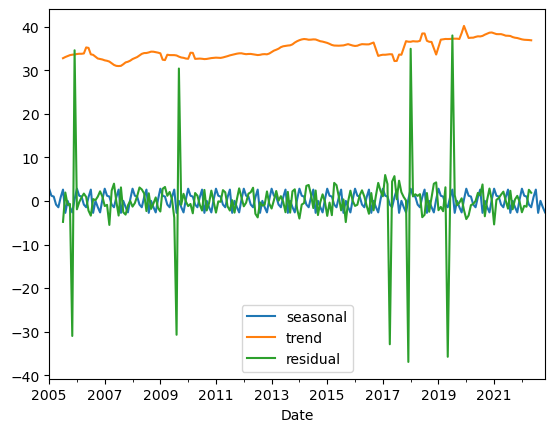

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result = seasonal_decompose(milk_quantity_yearly)
decompose_df = pd.DataFrame({"seasonal" : decompose_result.seasonal, "trend" : decompose_result.trend, "residual" : decompose_result.resid})
decompose_df.plot()